# Customer segmentation for an upcoming news outlet using latest Deloitte Digital Democracy survey data
#### Abhilash Biswas and Matt Lampl

### Overview:

Market segmentation is an important topic for businesses looking to launch new products and services. Using a hypothetical scenario of a news media outlet that is looking to launch in the near future, we use the Deloitte Digital Democracy survey data of 2011 to identify different customer segments that the company should target. We use several methods to identify interesting clusters of customer segments having distinct attitudes and behaviors towards subscriptions, media habits, purchases etc. In general, our focus of this project is to identify customers/segments that may be more willing to purchase a subscription for this news outlet.

#### Topic area 1: Market segmentation using unsupervised learning
Market segmentation is typically done on traditional demographic elements such as age, gender, location etc. In addition to exploring these categories, we apply KMeans unsupervised clustering algorithm to identify latent dimensions in the dataset that can provide important insights on different customer segments. 

#### Topic area 2: Supervised learning
Can we predict people who are more likely to purchase a subscription for the news agency? Using the variable 'willing to pay more news subscription without ads', we train a Random Forest classification model on the features available in the Deloitte digital democracy survey to answer this prediction question and perform some analysis on the outputs

#### Notebook organization:
- Section 1: Reading in the dataset, cleaning, dealing missing values
- Section 2: Exploratory data analysis
- Section 3: Unsupervised learning
- Section 4: Supervised learning
- Section 5: Concluding discussion

#### Data limitations
One of the major limitations is that this notebook contains only age and sex as the relevant demographic variables. Hence the segmentation analysis is limited. Although the notebook has other features like ethnicity, location etc, there is an imbalance in the dataset and all those dimensions are not fairly represented. Hence using those may incorrectly skew our analysis. Further, most of the feature variables are categorical, hence we are limited in the kind of analysis we can do. 

#### Github repository
We have organized this work in a github repository, which can be found here -- https://github.com/abhilashbiswas/customer_segmentation_for_news_outlet


### Section 1: Data reading in and cleaning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')

In [2]:
# Read in dataset
dds_11 = pd.read_excel("data/DDS11_Data_Extract_with_labels.xlsx")
column_names = pd.read_csv("data/Column Names.csv") # Manually created mapping of column names
dds_11.columns = column_names['New_Name']

In [3]:
# Replace all "Yes/No" columns with 1/0
def replace_yes_no(df, col):
    """
    This replaces all Yes answers with a 1 and all No/NULL answers with a 0.
    For all NULL answers in a YES/NO column, a 0 is appropriate given that these columns are either ranking questions or questions where NULL means No.
    """
    df[col] = df[col].apply(lambda x: 1 if x == 'Yes' else 0)
    
# Figure out which columns are yes/no columns and replace accordingly
yes_no_cols = [col for col in dds_11.columns if 'Yes' in set(dds_11[col]) or 'No' in set(dds_11[col])]

for col in yes_no_cols:
    replace_yes_no(dds_11, col)

# Replace NULLS in ranking columns with 0
ranking_cols = [col for col in dds_11.columns if col.split('_')[0] == 'rank']
for col in ranking_cols:
    dds_11[col] = dds_11[col].fillna(0)

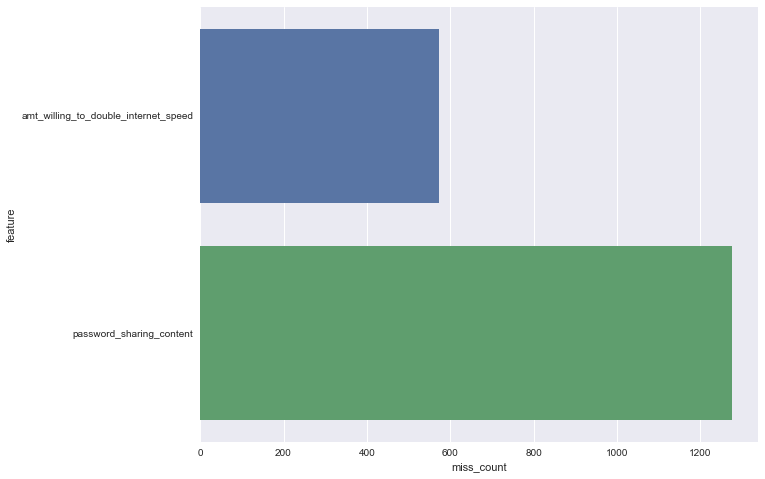

In [4]:
# Visualizing missing values
def plot_missing(theDataFrame, fs=(10,8)):
    """
    Graph the number of missing values in each column (each feature)
    
    return:
    None
    """
    # A new dataframe that contains the count of null items for each category (axis=0)
    missingvals_df = theDataFrame.isnull().sum(axis=0).reset_index()
    missingvals_df.columns = ['feature', 'miss_count'] # Rename the column names to feature and miss count
    missingvals_df = missingvals_df.loc[missingvals_df['miss_count'] > 0] # Filter out the features that have values for every entry
    missingvals_df = missingvals_df.sort_values(by='miss_count') # Sort

    # Plot
    fig, ax = plt.subplots(figsize=fs)
    sns.barplot(data=missingvals_df, x='miss_count', y='feature', orient='h', ax=ax)

plot_missing(dds_11)


In [5]:
# For Amount Willing to Pay to Double Internet Speed, the NULL values will be replaced with "N/A" since this is a categorical variable
dds_11['amt_willing_to_double_internet_speed'] = dds_11['amt_willing_to_double_internet_speed'].fillna("N/A")

# For Password Sharing Content, the NULL values will be replaced with "N/A" since this is a categorical variable
dds_11['password_sharing_content'] = dds_11['password_sharing_content'].fillna("N/A")

# Create a copy of this cleaned df for further processing
df = dds_11.copy()

In [6]:
# Make Categorical Variables
df['age_range'] = pd.Categorical(df['age_range'], 
                                 categories=['14-19', '20-26', '27-33',
                                             '34-50', '51-69', '70 or older'],
                                 ordered=True)
df['income'] = pd.Categorical(df['income'], 
               categories=['Less than $29,999', '$30,000 to $49,999',
                           '$50,000 to $99,999', '$100,000 to $299,999',
                           'More than $300,000', 'Do not know'], ordered=True)
df['willing_to_pay_no_ads_news'] = pd.Categorical(df['willing_to_pay_no_ads_news'],
                                                  categories=['Agree strongly', 'Agree somewhat',
                                                              'Disagree somewhat', 'Disagree strongly',
                                                              'N/A; I do not have a basis to answer'],
                                                 ordered=True)

### Section 2: Exploratory Data Analysis
1. Age Range
2. Gender
3. Region
4. Income
5. Ethnicitiy

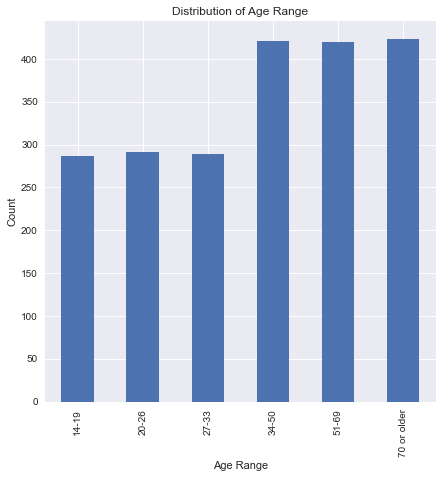

In [7]:
# Plot Distribution of Each of Those Groups

# Age Range
plt.figure(figsize=(7,7))
pd.Categorical(df['age_range'])\
    .value_counts()\
    .plot(kind='bar')
plt.title('Distribution of Age Range')
plt.xlabel('Age Range'); plt.ylabel('Count')
plt.show()

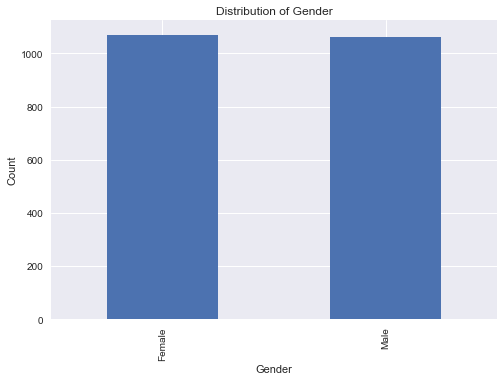

In [8]:
# Distribution of Gender
df['gender'].value_counts().plot(kind='bar')
plt.title('Distribution of Gender')
plt.xlabel('Gender'); plt.ylabel('Count')
plt.show()

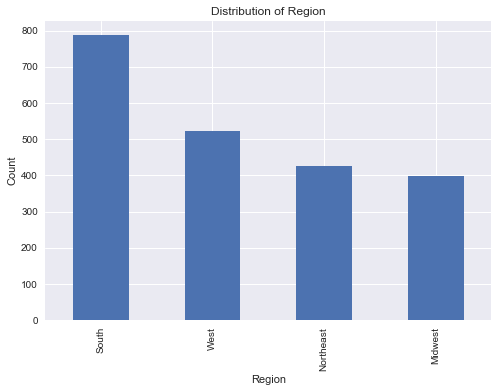

In [9]:
# Distribution of Region
df['region'].value_counts().plot(kind='bar')
plt.title('Distribution of Region')
plt.xlabel('Region'); plt.ylabel('Count')
plt.show()

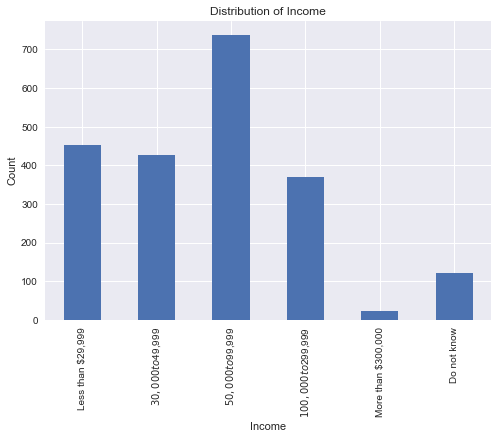

In [10]:
# Distribution of Income
pd.Categorical(df['income'])\
    .value_counts().plot(kind='bar')
plt.title('Distribution of Income')
plt.xlabel('Income'); plt.ylabel('Count')
plt.show()

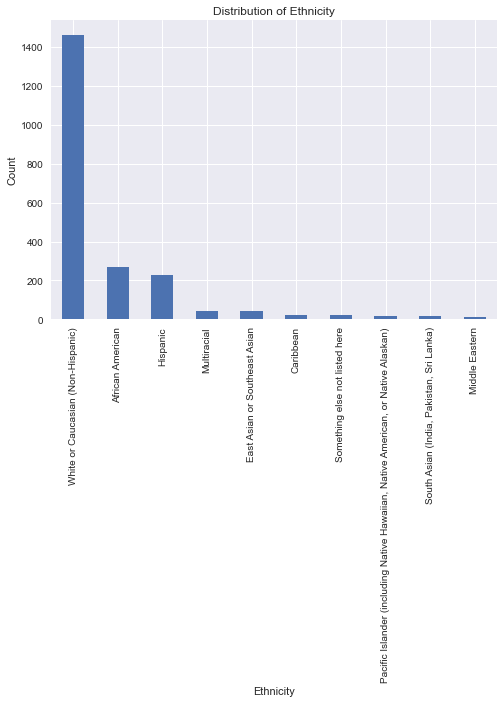

In [11]:
# Distribution of Ethnicity
df['ethnicity'].value_counts().plot(kind='bar')
plt.title('Distribution of Ethnicity')
plt.xlabel('Ethnicity'); plt.ylabel('Count')
plt.show()

### Breakdown of Habits By Group

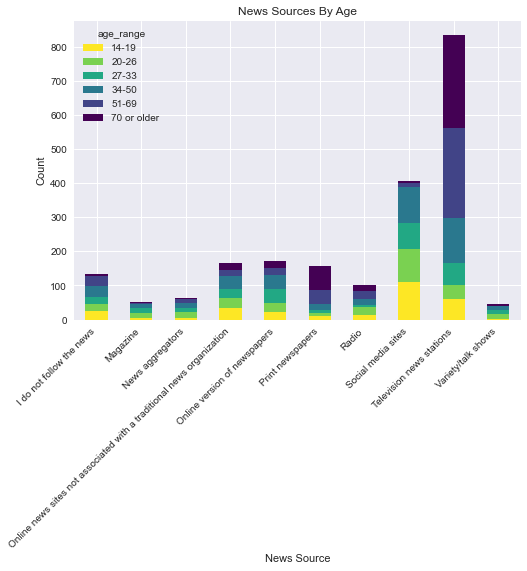

In [12]:
df[['age_range', 'news_source']].value_counts().reset_index()\
    .pivot(index='news_source', columns='age_range', values=0)\
    .plot(kind='bar', stacked=True, colormap='viridis_r')
plt.xticks(rotation=45, ha='right')
plt.title('News Sources By Age')
plt.xlabel('News Source'); plt.ylabel('Count')
plt.show()

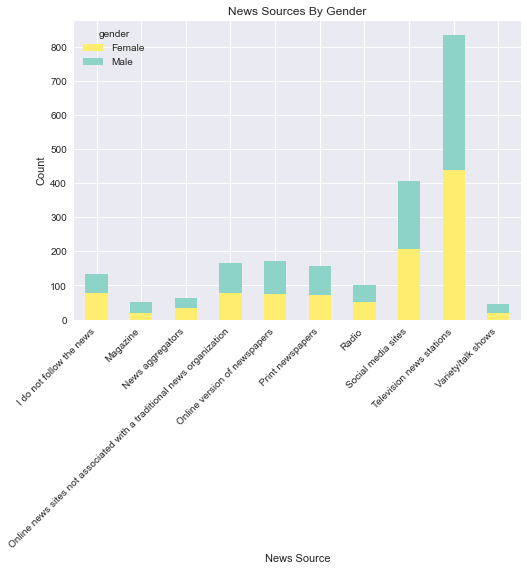

In [13]:
df[['gender', 'news_source']].value_counts().reset_index()\
    .pivot(index='news_source', columns='gender', values=0)\
    .plot(kind='bar', stacked=True, colormap='Set3_r')
plt.xticks(rotation=45, ha='right')
plt.title('News Sources By Gender')
plt.xlabel('News Source'); plt.ylabel('Count')
plt.show()

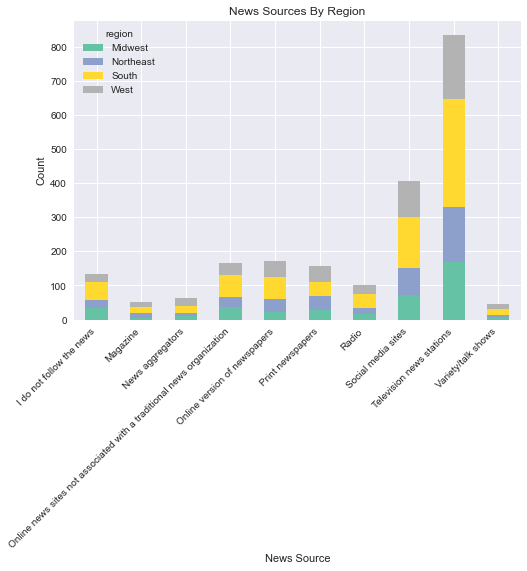

In [14]:
df[['region', 'news_source']].value_counts().reset_index()\
    .pivot(index='news_source', columns='region', values=0)\
    .plot(kind='bar', stacked=True, colormap='Set2')
plt.xticks(rotation=45, ha='right')
plt.title('News Sources By Region')
plt.xlabel('News Source'); plt.ylabel('Count')
plt.show()

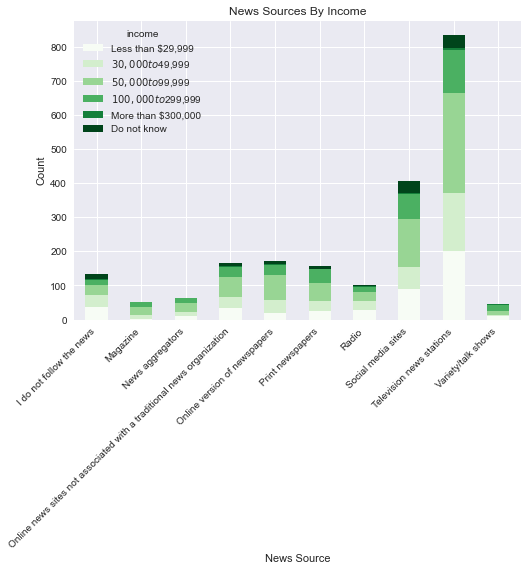

In [15]:
df[['income', 'news_source']].value_counts().reset_index()\
    .pivot(index='news_source', columns='income', values=0)\
    .plot(kind='bar', stacked=True, colormap='Greens')
plt.xticks(rotation=45, ha='right')
plt.title('News Sources By Income')
plt.xlabel('News Source'); plt.ylabel('Count')
plt.show()

Text(0.5, 1.0, 'I would rather pay for news online in exchange for not being exposed to advertisements\n')

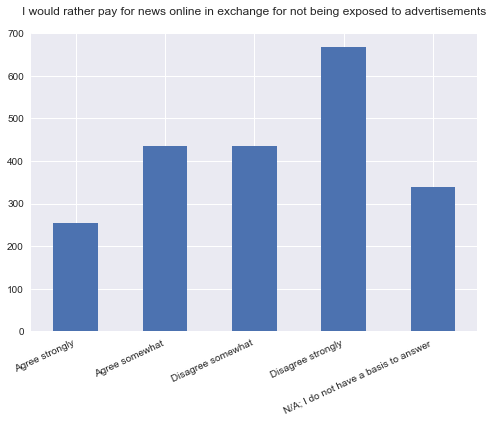

In [16]:
pd.Categorical(df['willing_to_pay_no_ads_news'])\
    .value_counts().plot(kind='bar')
plt.xticks(rotation=25, ha='right')
plt.title('I would rather pay for news online in exchange for not being exposed to advertisements\n')

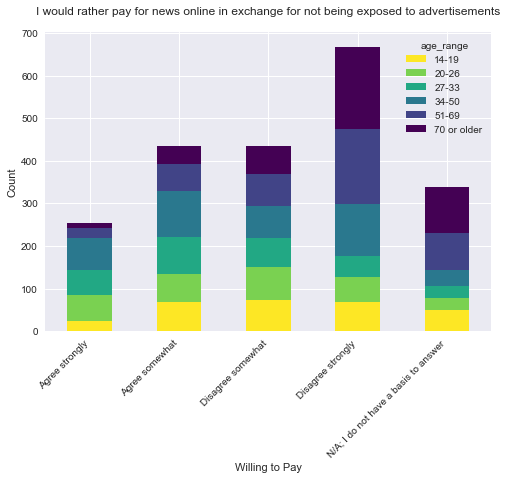

In [17]:
df[['willing_to_pay_no_ads_news', 'age_range']].value_counts().reset_index()\
    .pivot(index='willing_to_pay_no_ads_news', columns='age_range', values=0)\
    .plot(kind='bar', stacked=True, colormap='viridis_r')
plt.xticks(rotation=45, ha='right')
plt.title('I would rather pay for news online in exchange for not being exposed to advertisements\n')
plt.xlabel('Willing to Pay'); plt.ylabel('Count')
plt.show()

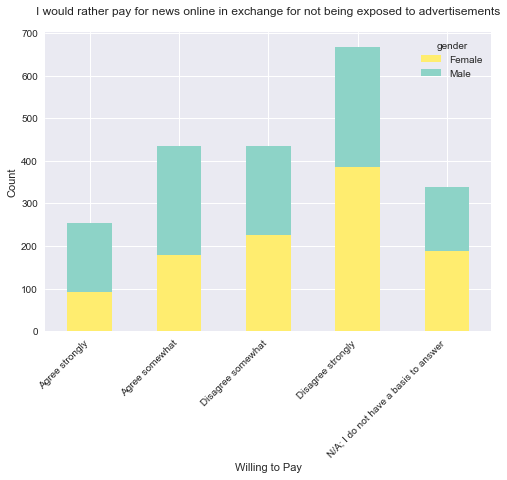

In [18]:
df[['willing_to_pay_no_ads_news', 'gender']].value_counts().reset_index()\
    .pivot(index='willing_to_pay_no_ads_news', columns='gender', values=0)\
    .plot(kind='bar', stacked=True, colormap='Set3_r')
plt.xticks(rotation=45, ha='right')
plt.title('I would rather pay for news online in exchange for not being exposed to advertisements\n')
plt.xlabel('Willing to Pay'); plt.ylabel('Count')
plt.show()

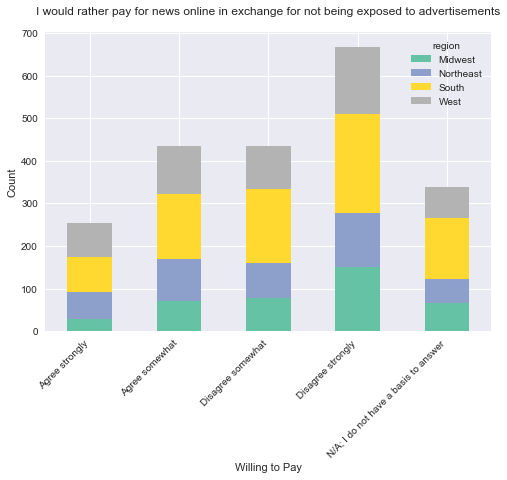

In [19]:
df[['willing_to_pay_no_ads_news', 'region']].value_counts().reset_index()\
    .pivot(index='willing_to_pay_no_ads_news', columns='region', values=0)\
    .plot(kind='bar', stacked=True, colormap='Set2')
plt.xticks(rotation=45, ha='right')
plt.title('I would rather pay for news online in exchange for not being exposed to advertisements\n')
plt.xlabel('Willing to Pay'); plt.ylabel('Count')
plt.show()

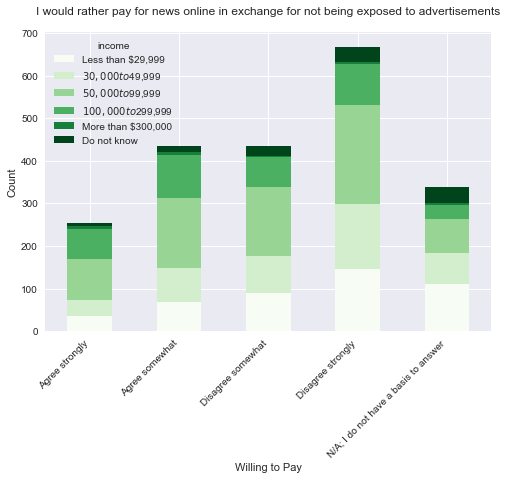

In [20]:
df[['willing_to_pay_no_ads_news', 'income']].value_counts().reset_index()\
    .pivot(index='willing_to_pay_no_ads_news', columns='income', values=0)\
    .plot(kind='bar', stacked=True, colormap='Greens')
plt.xticks(rotation=45, ha='right')
plt.title('I would rather pay for news online in exchange for not being exposed to advertisements\n')
plt.xlabel('Willing to Pay'); plt.ylabel('Count')
plt.show()

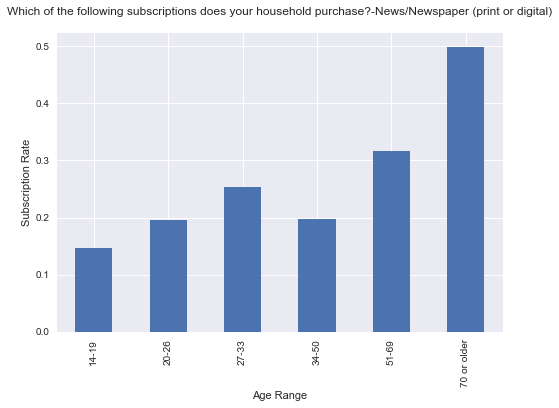

In [21]:
df[['age_range', 'subscriber_newspaper']]\
    .groupby('age_range')\
    .apply(lambda x: x['subscriber_newspaper'].sum() / x['age_range'].count())\
    .plot(kind='bar')
plt.title('Which of the following subscriptions does your household purchase?-News/Newspaper (print or digital)\n')
plt.xlabel('Age Range'); plt.ylabel('Subscription Rate')
plt.show()

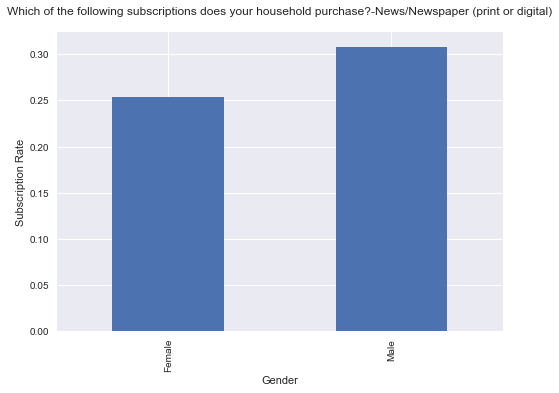

In [22]:
df[['gender', 'subscriber_newspaper']]\
    .groupby('gender')\
    .apply(lambda x: x['subscriber_newspaper'].sum() / x['gender'].count())\
    .plot(kind='bar')
plt.title('Which of the following subscriptions does your household purchase?-News/Newspaper (print or digital)\n')
plt.xlabel('Gender'); plt.ylabel('Subscription Rate')
plt.show()

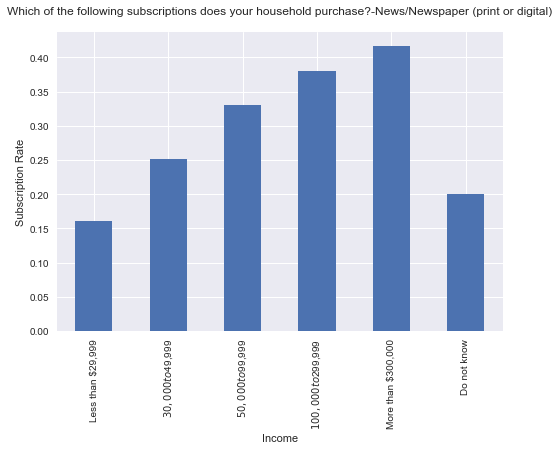

In [23]:
df[['income', 'subscriber_newspaper']]\
    .groupby('income')\
    .apply(lambda x: x['subscriber_newspaper'].sum() / x['income'].count())\
    .plot(kind='bar')
plt.title('Which of the following subscriptions does your household purchase?-News/Newspaper (print or digital)\n')
plt.xlabel('Income'); plt.ylabel('Subscription Rate')
plt.show()

### Section 3: Unsupervised learning

What are some latent factors for market segmentation. Can we cluster people into distinct groups and explore the characteristics of these groups?

In this section, we do the following analysis:

- Decide on a set of clustering feature variables relevant to our outcome of interest (willing to pay for news subscription without ads)
- Find an optimum K and cluster
- Visualize the clusters against income category, gender and age
- Visualize the clusters against top 2 principal compontents
- Find age distribution in the clusters and their willingness to pay
- Perform unsupervised clustering on 5 principal components to see if that yields anything different

In [24]:
#####################################
# Perform preprocessing required for clustering categorical variables
#####################################

# normalize the age data
df['age_norm'] = (df.age - df.age.mean()) / df.age.std()

# Get all willing to pay vars
willing_to_pay_vars = [col for col in df.columns if 'willing_to_pay' in col]
demographic_vars = ['age_norm', 'income', 'gender']

# Encode vars

var_map = {
    'Agree somewhat': 1,
    'Agree strongly': 2,
    'Disagree somewhat': 3,
    'Disagree strongly': 4,
    'N/A; I do not have a basis to answer': 5
}

for var in willing_to_pay_vars:
    df[var] = df[var].map(var_map)

# Convert categorical demographic variables to numerical features
income_map = {
    'Less than $29,999': 1,
    '$30,000 to $49,999': 2,
    '$50,000 to $99,999': 3,
    '$100,000 to $299,999': 4,
    'More than $300,000': 5,
    'Do not know': 6
}
df['income'] = df['income'].map(income_map)

gender_map = {
    'Male': 1,
    'Female': 2,
}
df['gender'] = df['gender'].map(gender_map)

ethnicity_map = {}
for i, ethno in enumerate(np.unique(df.ethnicity)):
    ethnicity_map[ethno] = i

df['ethnicity'] = df['ethnicity'].map(ethnicity_map)

clustering_vars = (willing_to_pay_vars + demographic_vars + ['ethnicity', 'children'] + [col for col in df.columns if 'plan_to_purchase' in col] +
                   [col for col in df.columns if 'home_entertainment' in col or 'subscriber' in col])
                        


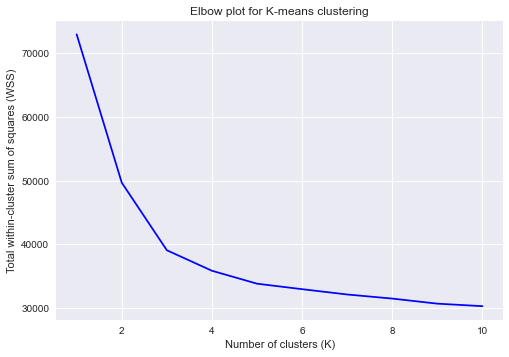

In [25]:
####################################
# Make elbow plot to choose K
####################################

X = df[clustering_vars]

# Define the range of K values to test
K_range = range(1, 11)

# Run the K-means algorithm for each value of K
WSS = []
for k in K_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    WSS.append(kmeans.inertia_)

# Plot the elbow plot
plt.plot(K_range, WSS, 'bx-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Total within-cluster sum of squares (WSS)')
plt.title('Elbow plot for K-means clustering')
plt.show()


We will go with K=3 and K=4

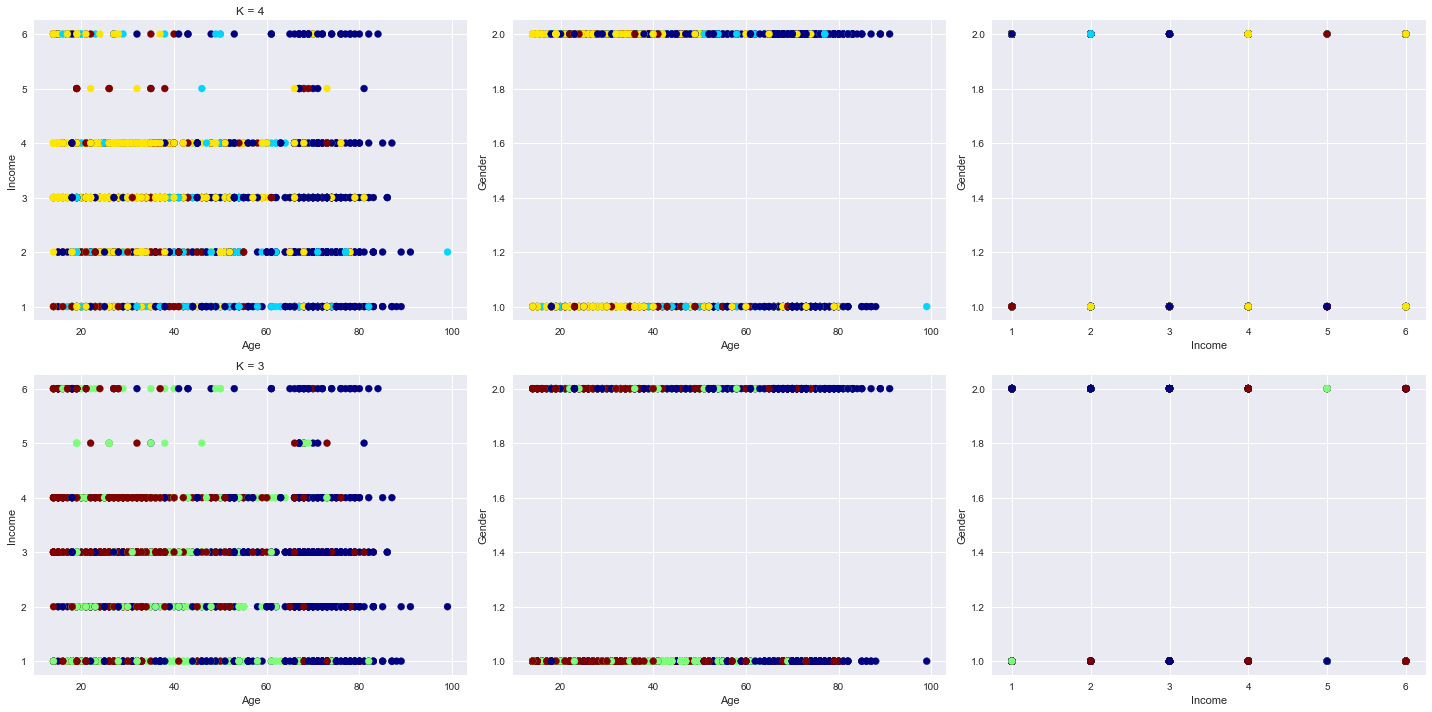

In [26]:
##############################
# Perform clustering and visualize
##############################

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

# Perform k-means clustering
k_values = [4, 3]

# create a figure with subplots
fig, axes = plt.subplots(len(k_values), len(demographic_vars), figsize=(20, 10))


# Iterate over each K-means value and create a scatter plot for age vs. income, age vs. gender, and income vs. gender
for i, k in enumerate(k_values):

    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df[clustering_vars])
    labels = kmeans.labels_

    # Create scatter plots for age vs. income, age vs. gender, and income vs. gender on this row
    axes[i, 0].scatter(df.age, df.income, c=labels, cmap='jet')
    axes[i, 0].set_title(f'K = {k}')
    axes[i, 0].set_xlabel('Age')
    axes[i, 0].set_ylabel('Income')
    
    axes[i, 1].scatter(df.age, df.gender, c=labels, cmap='jet')
    axes[i, 1].set_xlabel('Age')
    axes[i, 1].set_ylabel('Gender')
    
    axes[i, 2].scatter(df.income, df.gender, c=labels, cmap='jet')
    axes[i, 2].set_xlabel('Income')
    axes[i, 2].set_ylabel('Gender')

plt.tight_layout()
plt.show()

We don't see very meaningful separation when plotting the clusters on some of the demographic variables, In other words, there don't seem to be meaningful clusters formed on the 3 available demographic dimensions

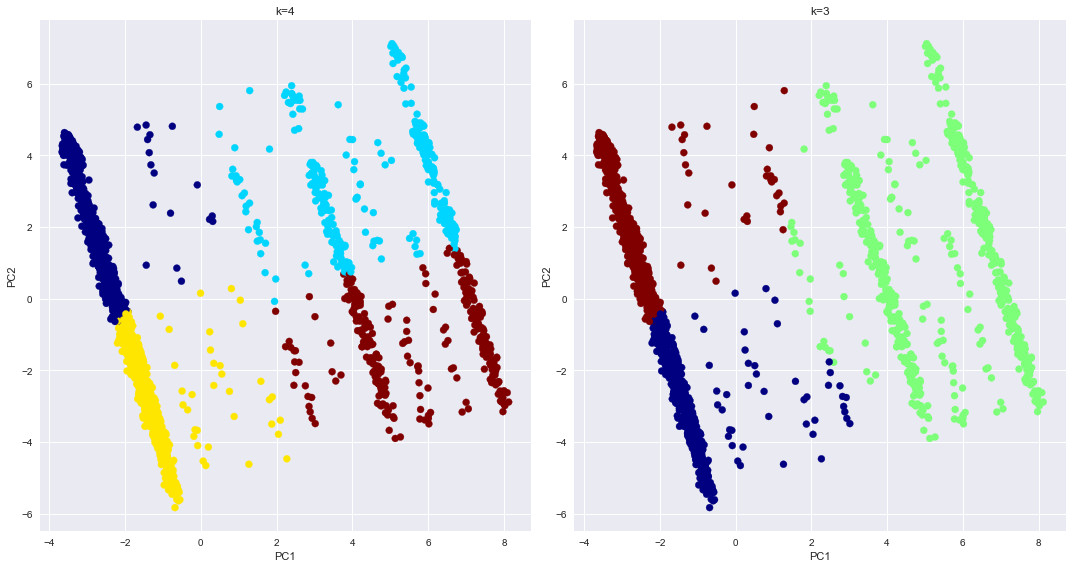

In [27]:
##############################
# Plotting the same clusters as above, but on top 2 principal components
##############################
from sklearn.decomposition import PCA

# Perform PCA to reduce dimensionality to 2 principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df[clustering_vars])

# Add the 2 principal components to the dataframe
df['PC1'] = X_pca[:, 0]
df['PC2'] = X_pca[:, 1]

# create a figure with subplots
fig, axes = plt.subplots(1, len(k_values), figsize=(15, 8))


# Iterate over each K-means value and create a scatter plot for age vs. income, age vs. gender, and income vs. gender
for i, k in enumerate(k_values):

    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df[clustering_vars])
    labels = kmeans.labels_
    
    # Plot PC1 vs PC2
    axes[i].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='jet')
    axes[i].set_xlabel('PC1')
    axes[i].set_ylabel('PC2')
    axes[i].set_title(f'k={k}')
        
plt.tight_layout()
plt.show()
    



Now we start to see some meaningful separation. For example, we can see that there are distinct clusters for different values of PC1 and PC2. For K = 3, let's check what are the differences in the different assigned clusters

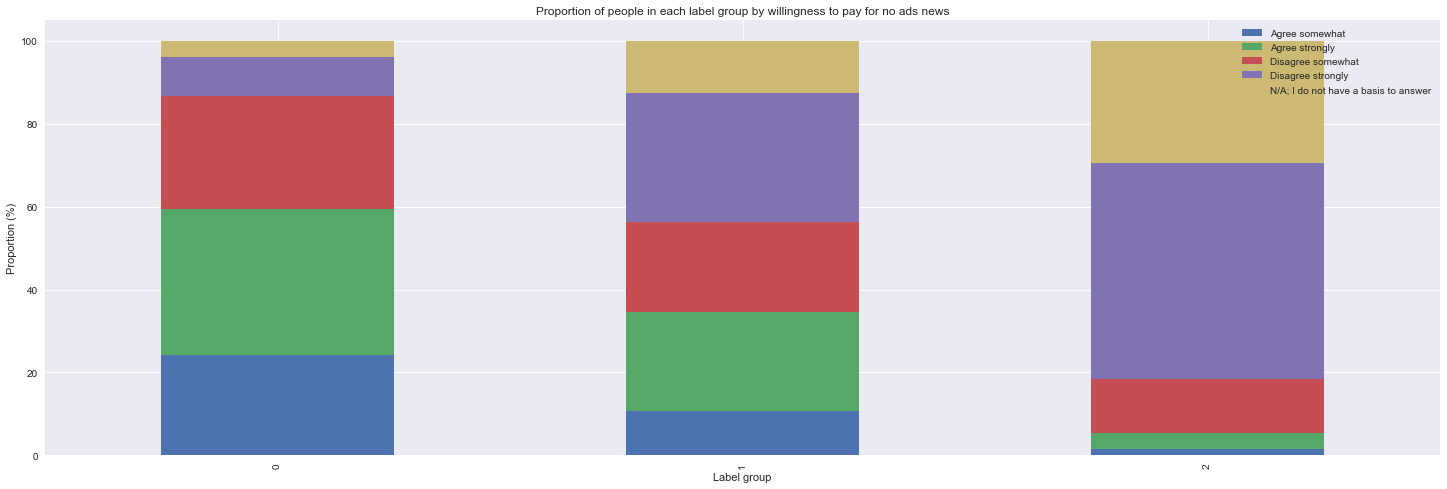

In [28]:
######################################
# Checking differences in clusters
######################################

df_new = df.copy()

df_new['labels'] = labels

# Group the data by label and willing_to_pay_no_ads_news
grouped = df_new.groupby(['labels', 'willing_to_pay_no_ads_news'])

# Compute the count of each group
counts = grouped.size()

# Compute the proportion of each group by label
proportions = counts.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

# Reshape the proportions to a pivot table format
proportions = proportions.reset_index()
proportions = proportions.pivot(index='labels', columns='willing_to_pay_no_ads_news', values=0)
proportions = proportions.set_axis(list(({'1':'Agree somewhat', '2':'Agree strongly', '3':'Disagree somewhat', '4':'Disagree strongly', '5':'N/A; I do not have a basis to answer'}).values()), axis=1)


proportions.plot(kind='bar', stacked=True, figsize=(25,8))
plt.xlabel('Label group')
plt.ylabel('Proportion (%)')
plt.title('Proportion of people in each label group by willingness to pay for no ads news')
plt.show()


We can see that label group 1 and 2 have a higher change of agreeing to pay for news subscription. While we don't have a wider set of demographic variables, and unsupervised learning was used to find latent groups beyond demographic variables, let's check the age distribution in these groups

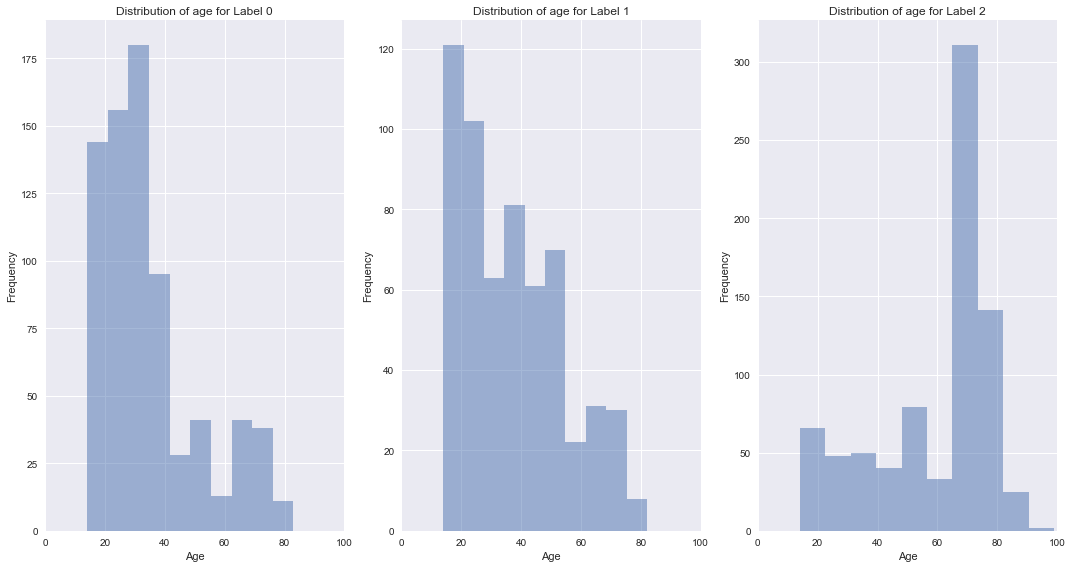

In [29]:
# Create a 1x3 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 8))

# Plot the distribution of age for each value of label in a separate subplot
for i, label in enumerate([0, 1, 2]):
    ax = axes[i]
    df_new[df_new['labels'] == label]['age'].plot(kind='hist', alpha=0.5, ax=ax)
    ax.set_xlabel('Age')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of age for Label {label}')
    ax.set_xlim(0, 100)

# Adjust the layout of the subplots
plt.tight_layout()

# Show the plot
plt.show()


We can see that the distribution skews young. Let's perform another unsupervised clustering, but instead of direct variables, use principal components as the features

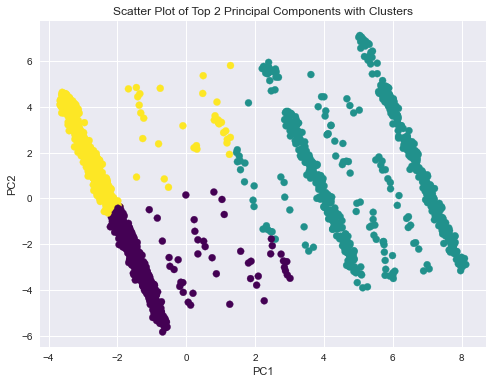

In [30]:
#############################
# Another unsupervised learning, this time clustering on principal components
#############################

X = df[clustering_vars]

# Perform PCA to get the top 5 principal components
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

# Apply k-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_pca)

# Get the cluster labels
labels = kmeans.labels_

# Plot a scatter plot between PC1 and PC2 with color labels for each cluster
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatter Plot of Top 2 Principal Components with Clusters')
plt.show()


We see similar behaviour as clustering on original variables and plotting against top 2 PC. Plotting PC1 against PC3 is also interesting

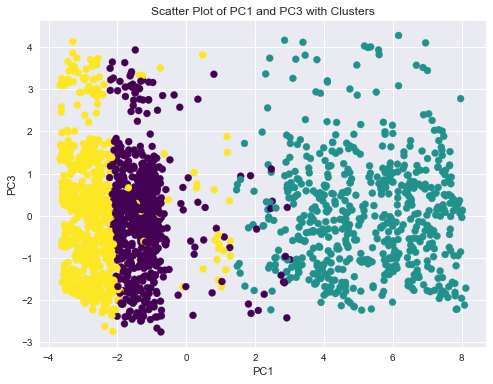

In [31]:
# Plot a scatter plot between PC1 and PC2 with color labels for each cluster
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 2], c=labels, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.title('Scatter Plot of PC1 and PC3 with Clusters')
plt.show()


### Section 4: Supervised learning

Can we predict the outcome of the question: Are you willing to pay more to have ad free news access?

In [49]:
# Since multiple operations have been performed on this dataset, let's start fresh
df = dds_11.copy()

# Dropping the ID column
df = df.drop(columns=['ID', 'final_weights'])

# Make Categorical Variables
df['age_range'] = pd.Categorical(df['age_range'], 
                                 categories=['14-19', '20-26', '27-33',
                                             '34-50', '51-69', '70 or older'],
                                 ordered=True)
df['income'] = pd.Categorical(df['income'], 
               categories=['Less than $29,999', '$30,000 to $49,999',
                           '$50,000 to $99,999', '$100,000 to $299,999',
                           'More than $300,000', 'Do not know'], ordered=True)

willing_to_pay_vars = [col for col in df.columns if 'willing_to_pay' in col]

for var in willing_to_pay_vars:
    df[var] = pd.Categorical(df[var],
                                    categories=['Agree strongly', 'Agree somewhat',
                                                'Disagree somewhat', 'Disagree strongly',
                                                'N/A; I do not have a basis to answer'],
                                    ordered=True)

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay

# categoricals
target = 'willing_to_pay_no_ads_news'
df_x = df.drop(columns=[target])
df_x = pd.get_dummies(df_x)
df_y = df[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

# Convert the target variable to integer labels
le = LabelEncoder()
y = le.fit_transform(df[target])

# Train a random forest classifier
rf = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=15, min_samples_split=10, max_features='sqrt')
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=np.unique(df[target]))

# Print the classification report
print(report)
cm = confusion_matrix(y_test, y_pred)

                                      precision    recall  f1-score   support

                      Agree somewhat       0.45      0.61      0.52        75
                      Agree strongly       0.67      0.29      0.40        49
                   Disagree somewhat       0.55      0.52      0.54       100
                   Disagree strongly       0.74      0.82      0.78       137
N/A; I do not have a basis to answer       0.81      0.71      0.76        66

                            accuracy                           0.63       427
                           macro avg       0.64      0.59      0.60       427
                        weighted avg       0.65      0.63      0.63       427



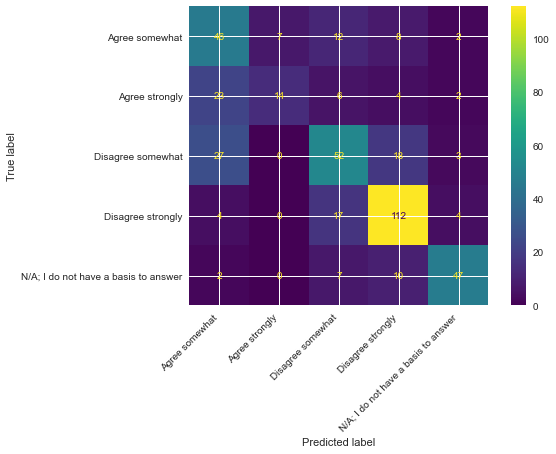

In [51]:
disp = ConfusionMatrixDisplay(cm, display_labels=rf.classes_)
disp.plot()
plt.xticks(rotation=45, ha='right')
plt.show()

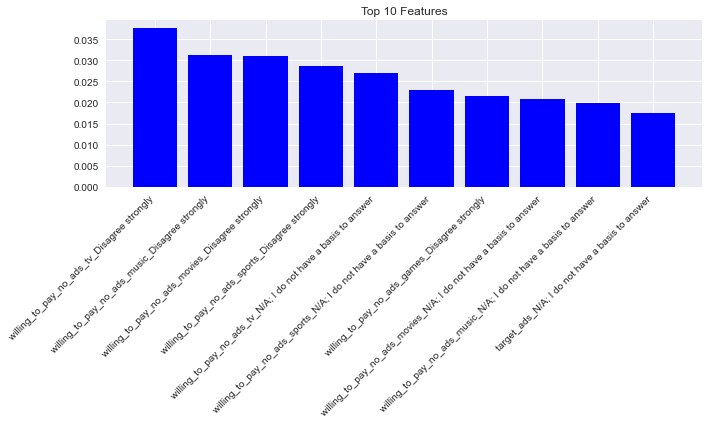

In [52]:
# Plot feature importances
importances = rf.feature_importances_

# Sort the features by importance
indices = np.argsort(importances)[::-1]

# Get the top 10 features and their importances
top_features = df_x.columns[indices][:10]
top_importances = importances[indices][:10]

# Plot the top 10 features
plt.figure(figsize=(10,6))
plt.title('Top 10 Features')
plt.bar(range(len(top_importances)), top_importances, color='blue', align='center')
plt.xticks(range(len(top_importances)), top_features, rotation=45, ha='right')
plt.tight_layout()
plt.show()


What happens if we remove the willingness to pay variables and then try to predict?

In [53]:
# try a random forest after removing the willingness to pay variables
# categoricals
target = 'willing_to_pay_no_ads_news'
other_willingness_cols = [col for col in df.columns if 'willing_to_pay' in col and 'willing_to_pay_no_ads_news' not in col]
cols_to_drop = [target] + other_willingness_cols

df_x = df.drop(columns=cols_to_drop)
df_x = pd.get_dummies(df_x)
df_y = df[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

# Convert the target variable to integer labels
le = LabelEncoder()
y = le.fit_transform(df[target])

# Train a random forest classifier
rf = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=15, min_samples_split=10, max_features='sqrt')
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=np.unique(df[target]))

# Print the classification report
print(report)
cm = confusion_matrix(y_test, y_pred)

                                      precision    recall  f1-score   support

                      Agree somewhat       0.37      0.41      0.39        75
                      Agree strongly       0.58      0.22      0.32        49
                   Disagree somewhat       0.39      0.22      0.28       100
                   Disagree strongly       0.51      0.81      0.63       137
N/A; I do not have a basis to answer       0.75      0.58      0.65        66

                            accuracy                           0.50       427
                           macro avg       0.52      0.45      0.45       427
                        weighted avg       0.50      0.50      0.47       427



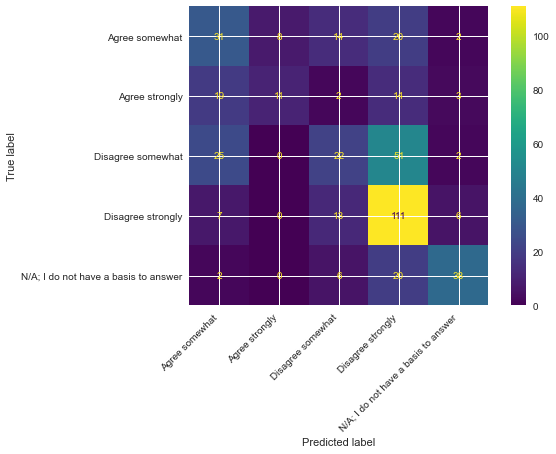

In [54]:
disp = ConfusionMatrixDisplay(cm, display_labels=rf.classes_)
disp.plot()
plt.xticks(rotation=45, ha='right')
plt.show()

Interestingly, when we remove the other willingness to pay features, although the overall accuracy goes down, the precision of the 2 groups we are interested in almost stays the same

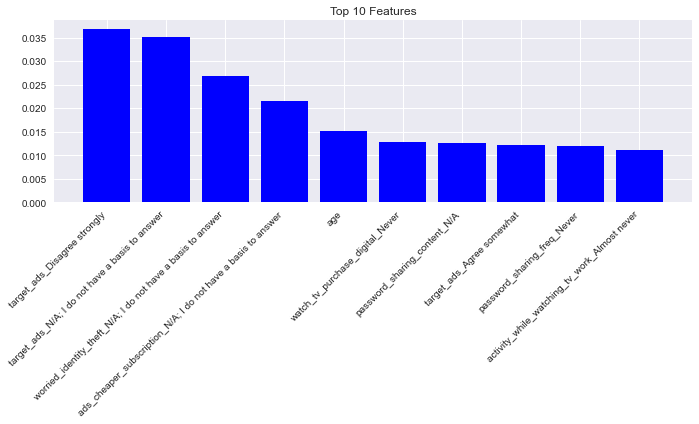

In [55]:
# Plot feature importances
importances = rf.feature_importances_

# Sort the features by importance
indices = np.argsort(importances)[::-1]

# Get the top 10 features and their importances
top_features = df_x.columns[indices][:10]
top_importances = importances[indices][:10]

# Plot the top 10 features
plt.figure(figsize=(10,6))
plt.title('Top 10 Features')
plt.bar(range(len(top_importances)), top_importances, color='blue', align='center')
plt.xticks(range(len(top_importances)), top_features, rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Section 5: Concluding discussion

From the unsupervised learning, we see that it is possible to achieve somewhat of a distinct clustering to identify clusters who may be willing to pay more. These customers generally skew younger. Hence, targetting advertisements on social media would help the news outlet get more subscribers

From the supervised learning, we saw that although the overall accuracy of the model is average, the categories for 'agree strongly' and 'agree somewhat', which is what we are interested in, have decent precision. From feature important, it seems that people who agree to pay for other services are also likely to pay for news subscription. If we remove these features, we see that those who are strongly against targeted ads a are likely to pay more for subscription. 